Det her fungere rigtigt fint. Kommer nok til at tage 45 timerish at køre. Det er ikke sikkert du har nok ram, men resultaterne kan gemmes undervejs i pickles, så det burde være fint. Lige nu henter du map fra 10 random non-zero oberservation. Det skal op på 100. Du skal overveje om det kun skal være tidslinjer med 2 eller flere events det skal med. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pymc3.gp.util import plot_gp_dist
#import matplotlib.cm as cmap

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
np.random.seed(42)

import theano
import theano.tensor as tt
import pymc3 as pm

import pickle

import time

pm.__version__

'3.6'

In [2]:
pkl_file = open('full_df.pkl', 'rb')

df = pickle.load(pkl_file)

pkl_file.close()

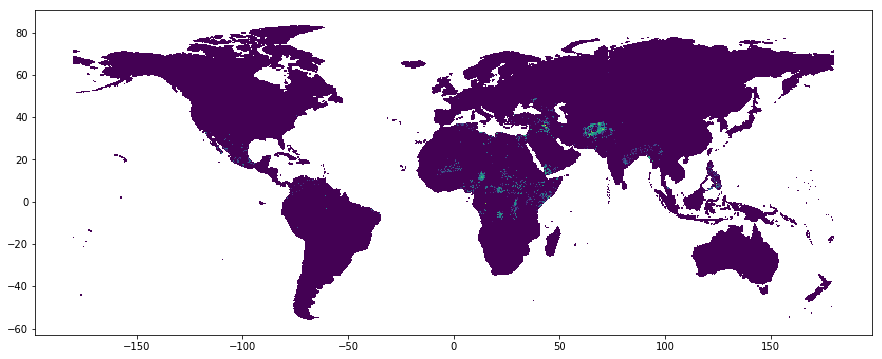

In [3]:
df[df['year']==2017].plot(column = 'log_best', figsize=(15, 15))
plt.show()

### Test gids:  
- none-zeroes: 209956, 194077 ,182658, 182659, 182656
- zeroes: 182656, 182320, 209950, 209930, 209730

In [92]:
# du kan overveje at lave map kun på obs der har mere en et conflcit år.

gid_list = np.random.choice(df[df['best']>0]['gid'].unique(),1000) # random non zeores. Fungere godt med 100..

df_sorted = df[df['gid'].isin(gid_list)].sort_values(['gid','year'])

In [93]:
df[df['best']>0]['gid'].unique().shape

(5429,)

### Vedr. X_new

** Ændre X_new så den incorporere de hele år... ** or så er 2030 nice at have med for visualiseringen, men det er way out i forhold til hvad modellen skal..
Appropos så kan du også overveje at have et X_new for visualisering og et for den egentlige implimenterig der kun har hele år med...


In [94]:
X = np.array(df_sorted['year']).reshape(-1,1)
#X = df_sorted['year'].copy()

y = np.array(df_sorted['log_best'])
#y = df_sorted['best'].copy() # try with log(best) as well

# you need to add a little bit of noise to y, if you have zeroes!
y = y + np.random.normal(0,0.1,len(y))

# index
index = np.array(df_sorted['gid'])

# new values from x=1989 to x=2020

max_forcast_year = 2031
X_new = np.linspace(df_sorted['year'].min(), max_forcast_year, 100)[:,None]

# Just for plotting
pred_years =  np.arange(df_sorted['year'].max(), max_forcast_year, 1)



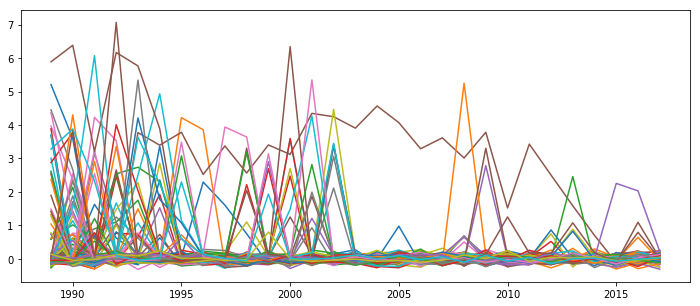

In [95]:
fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index)[0:100]):
    plt.plot(X[index == j],y[index==j])
    
plt.show()

**Change to log, reduse noise to 0.1**
SHould make it zero inflated for computational reasons not least.

# Shared
Virker fint med map. NOk den eneste realistiske løsning... Tidsmæssigt.
Hvi du inkoorporere short l_noice og small/medium term irregularities kunne det godt blive fint.

https://docs.pymc.io/notebooks/GP-MaunaLoa.html

og så skal du forholde dig kritisk til din mean function..

# MAP from sample:

In [40]:
# step0

time0 = time.time()

with pm.Model() as model:
    
    # long term trend
    ℓ_long = pm.Gamma("ℓ_long", alpha=2, beta=2, shape = 1)
    η_long = pm.HalfCauchy("η_long", beta=5, shape = 1)
    
    #short term trend
    ℓ_short = pm.Gamma("ℓ_short", alpha=2, beta=5, shape = 1)
    η_short = pm.HalfCauchy("η_short", beta=5, shape = 1)
#     α = pm.Gamma("α", alpha=5, beta=2)
    
    # noise model
    σ = pm.HalfCauchy("σ", beta=5, shape = 1)

    
# sample to fit map: 
    gp_list = []
    gp_long_list = []
    gp_short_list = []

    for i, j in enumerate(np.unique(index)[0:10]):
        
#         mean = pm.gp.mean.Constant(np.mean(y[index == j]))
#         mean = pm.gp.mean.Constant(0)
        
        cov_long = η_long **2 * pm.gp.cov.ExpQuad(1, ℓ_long)
        cov_short = η_short ** 2 * pm.gp.cov.ExpQuad(1, ℓ_short ) 
#         cov_short = η_short ** 2 * pm.gp.cov.RatQuad(1, ℓ_short, α)
        
        
        gp_long = pm.gp.Marginal(cov_func=cov_long)
        gp_short = pm.gp.Marginal(cov_func=cov_short)

        gp = gp_long + gp_short
        
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X[index == j], y=y[index == j], noise= σ)
        
        gp_list.append(gp)
        gp_long_list.append(gp_long)
        gp_short_list.append(gp_short)
        

In [41]:
#step1

time1 = time.time()

with model:
    mp = pm.find_MAP()
#     mp = pm.sample()
    

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -446.35, ||grad|| = 1.311: 100%|██████████| 19/19 [00:00<00:00, 27.96it/s]  


In [44]:
time2 = time.time()


In [45]:
step0t = (time1 - time0)/60
step1t = (time2 - time1)/60

stepallt = (time2 - time0)/60

print('step 0: {}min \n step 1: {} \n time total: {}min'.format(step0t, step1t, stepallt))

step 0: 0.26819645961125693min 
 step 1: 2.1807525555292764 
 time total: 2.4489490151405335min


map 7.5 min

In [46]:
mp

{'η_long': array([0.8067457]),
 'η_long_log__': array([-0.21474678]),
 'η_short': array([0.61956853]),
 'η_short_log__': array([-0.47873196]),
 'σ': array([0.69588358]),
 'σ_log__': array([-0.3625729]),
 'ℓ_long': array([3.66334112]),
 'ℓ_long_log__': array([1.29837561]),
 'ℓ_short': array([0.19993777]),
 'ℓ_short_log__': array([-1.6097491])}

# Full set:

In [96]:
# step0

time_0 = time.time()

with pm.Model() as model:
    
    # long term trend
    ℓ_long = pm.Gamma("ℓ_long", alpha=2, beta=2, shape = 1)
    η_long = pm.HalfCauchy("η_long", beta=5, shape = 1)
    
    #short term trend
    ℓ_short = pm.Gamma("ℓ_short", alpha=2, beta=5, shape = 1)
    η_short = pm.HalfCauchy("η_short", beta=5, shape = 1)
#     α = pm.Gamma("α", alpha=5, beta=2)
    
    # noise model
    σ = pm.HalfCauchy("σ", beta=5, shape = 1)

    
# sample to fit map: 
    gp_list = []
    gp_long_list = []
    gp_short_list = []

    for i, j in enumerate(np.unique(index)):
        
#         mean = pm.gp.mean.Constant(np.mean(y[index == j]))
#         mean = pm.gp.mean.Constant(0)
        
        cov_long = η_long **2 * pm.gp.cov.ExpQuad(1, ℓ_long)
        cov_short = η_short ** 2 * pm.gp.cov.ExpQuad(1, ℓ_short ) 
#         cov_short = η_short ** 2 * pm.gp.cov.RatQuad(1, ℓ_short, α)
        
        
        gp_long = pm.gp.Marginal(cov_func=cov_long)
        gp_short = pm.gp.Marginal(cov_func=cov_short)

        gp = gp_long + gp_short
        
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X[index == j], y=y[index == j], noise= σ)
        
        gp_list.append(gp)
        gp_long_list.append(gp_long)
        gp_short_list.append(gp_short)
        

In [97]:
time_1 = time.time()

mu_list = []
var_list = []
mu_long_list = []
var_long_list = []
mu_short_list = []
var_short_list = []

for i, j in enumerate(np.unique(index)):
    mu, var = gp_list[i].predict(X_new, point=mp, 
                                 diag=True)
    
    
    mu_long, var_long = gp_long_list[i].predict(X_new, point=mp,
                                      given = {'gp' : gp_list[i], 'X' : X[index == j], 'y' : y[index == j], 'noise' : σ },
                                      diag=True)
    
    
    mu_short, var_short = gp_short_list[i].predict(X_new, point=mp,
                                      given = {'gp' : gp_list[i], 'X' : X[index == j], 'y' : y[index == j], 'noise' : σ },
                                      diag=True)
    
    
    mu_list.append(mu)
    var_list.append(var)
    
    mu_long_list.append(mu_long)
    var_long_list.append(var_long)
    
    mu_short_list.append(mu_short)
    var_short_list.append(var_short)
    
    print('{}/{}'.format(i,np.unique(index).shape[0]), end = '-')
    
    
time_2 = time.time()


time_step1 = (time_1 - time_0)/60
time_step2 = (time_2 - time_1)/60
time_total = (time_2 - time_0)/60

print('\n first step: {}min \n second step: {}min \n total {}min'.format(time_step1, time_step2, time_total))

0/925-1/925-2/925-3/925-4/925-5/925-6/925-7/925-8/925-9/925-10/925-11/925-12/925-13/925-14/925-15/925-16/925-17/925-18/925-19/925-20/925-21/925-22/925-23/925-24/925-25/925-26/925-27/925-28/925-29/925-30/925-31/925-32/925-33/925-34/925-35/925-36/925-37/925-38/925-39/925-40/925-41/925-42/925-43/925-44/925-45/925-46/925-47/925-48/925-49/925-50/925-51/925-52/925-53/925-54/925-55/925-56/925-57/925-58/925-59/925-60/925-61/925-62/925-63/925-64/925-65/925-66/925-67/925-68/925-69/925-70/925-71/925-72/925-73/925-74/925-75/925-76/925-77/925-78/925-79/925-80/925-81/925-82/925-83/925-84/925-85/925-86/925-87/925-88/925-89/925-90/925-91/925-92/925-93/925-94/925-95/925-96/925-97/925-98/925-99/925-100/925-101/925-102/925-103/925-104/925-105/925-106/925-107/925-108/925-109/925-110/925-111/925-112/925-113/925-114/925-115/925-116/925-117/925-118/925-119/925-120/925-121/925-122/925-123/925-124/925-125/925-126/925-127/925-128/925-129/925-130/925-131/925-132/925-133/925-134/925-135/925-136/925-137/925-138/92

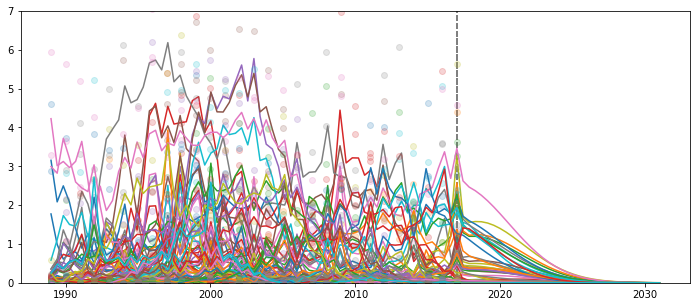

In [111]:

fig = plt.figure(figsize=(12,5))

start = 100
end = 200

for i, j in enumerate(np.unique(index)[start:end]):
    
    i = i + start
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(X_new, mu_list[i], color = color)
    plt.plot(X[index == j], y[index == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))



plt.ylim(0,7)
plt.show()

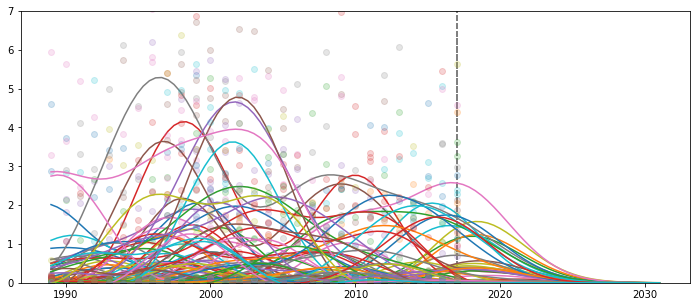

In [115]:

fig = plt.figure(figsize=(12,5))    

for i, j in enumerate(np.unique(index)[start:end]):
    i = i + start

    color = 'C' + str(i)[-1] # reiterates after 9

    plt.plot(X_new, mu_long_list[i], color = color)
    plt.plot(X[index == j], y[index == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))

plt.ylim(0,7)
plt.show()

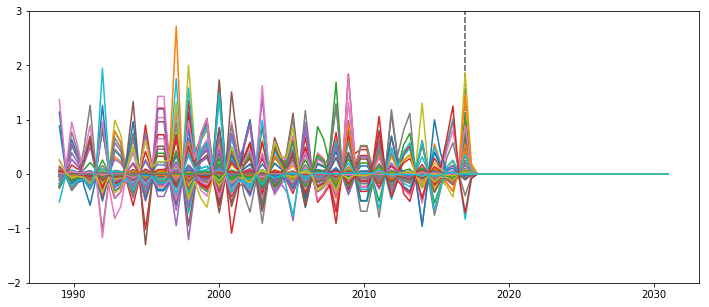

In [113]:

fig = plt.figure(figsize=(12,5))
    
for i, j in enumerate(np.unique(index)[start:end]):
    i = i + start

    color = 'C' + str(i)[-1] # reiterates after 9

    plt.plot(X_new, mu_short_list[i], color = color)
    plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))


plt.ylim(-2,3)
plt.show()